## Group 4 Data Mining Course Project
## Opioid Analysis

In [1]:
from subprocess import check_output
import numpy as np
import pandas as pd
import re
from bokeh.io import output_notebook
from bokeh.sampledata import us_states
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, Range1d
import matplotlib.pyplot as plt
%matplotlib inline
output_notebook()

# Import function to compute accuracy
from sklearn.metrics import accuracy_score
import pandas as pd
# Import function to split data
from sklearn.model_selection import train_test_split
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
#### Bagging Classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
#### Boosting Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

Loading BokehJS ...

C:\Users\Derek\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Derek\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Loading and exploring the data

In [2]:
opioids_df = pd.read_csv('opioids.csv')
od_df = pd.read_csv('overdoses.csv')
presciber_df = pd.read_csv('prescriber-info.csv')

In [3]:
opioids_df.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [4]:
od_df.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


In [5]:
presciber_df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [6]:
presciber_df.shape

(25000, 256)

## Cleaning up data 
- Removing states that do not map well
- Appending columns for categorical data using numeric label encoder

In [7]:
od_df['Deaths'] = od_df['Deaths'].apply(lambda x: float(re.sub(',', '', x)))
od_df['Population'] = od_df['Population'].apply(lambda x: float(re.sub(',', '', x)))

od_df = od_df.sort_values(by='Abbrev')
od_df = od_df[od_df['Abbrev'] != 'AK']
od_df = od_df[od_df['Abbrev'] != 'HI']

In [8]:
us_states = us_states.data.copy()
state_abbrevs = sorted(us_states.keys())
state_abbrevs.remove('DC')
state_abbrevs.remove('AK')
state_abbrevs.remove('HI')

In [9]:
le = preprocessing.LabelEncoder()

presciber_df['Gender1'] = le.fit_transform(presciber_df['Gender'].values)
presciber_df['State1'] = le.fit_transform(presciber_df['State'].values)
presciber_df['Specialty1'] = le.fit_transform(presciber_df['Specialty'].values)

In [10]:
presciber_df.dtypes

NPI                                int64
Gender                            object
State                             object
Credentials                       object
Specialty                         object
ABILIFY                            int64
ACETAMINOPHEN.CODEINE              int64
ACYCLOVIR                          int64
ADVAIR.DISKUS                      int64
AGGRENOX                           int64
ALENDRONATE.SODIUM                 int64
ALLOPURINOL                        int64
ALPRAZOLAM                         int64
AMIODARONE.HCL                     int64
AMITRIPTYLINE.HCL                  int64
AMLODIPINE.BESYLATE                int64
AMLODIPINE.BESYLATE.BENAZEPRIL     int64
AMOXICILLIN                        int64
AMOX.TR.POTASSIUM.CLAVULANATE      int64
AMPHETAMINE.SALT.COMBO             int64
ATENOLOL                           int64
ATORVASTATIN.CALCIUM               int64
AVODART                            int64
AZITHROMYCIN                       int64
BACLOFEN        

## Determining Death Rate by State
And plotting on map

In [11]:
od_df['Relative_Deaths'] = od_df['Deaths'] / od_df['Population']

In [12]:
Relative_Deaths_rnd = round(od_df['Relative_Deaths'], 9)
Relative_Deaths_rnd.head()

#od_df['Relative_Deaths']

0    0.000150
3    0.000120
2    0.000183
4    0.000118
5    0.000171
Name: Relative_Deaths, dtype: float64

In [13]:
state_xs = [us_states[code]["lons"] for code in state_abbrevs]
state_ys = [us_states[code]["lats"] for code in state_abbrevs]

min_x = min([min(s) for s in state_xs])
max_x = max([max(s) for s in state_xs])
min_y = min([min(s) for s in state_ys])
max_y = max([max(s) for s in state_ys])

In [14]:
# from here: http://nbviewer.jupyter.org/github/pybokeh/jupyter_notebooks/blob/master/bokeh/state_choropleth_example.ipynb
colors = ["#99DCF0", "#7DB1C1", "#5D818C", "#3A4F56", "#1F2A2D", "#040506"]
state_colors = []
maxDeaths = od_df['Relative_Deaths'].max()
for state in state_abbrevs:
    try:
        # get the value for the state
        rate = od_df[od_df['Abbrev']==state]['Relative_Deaths'].values[0]
        # Normalize the value by dividing it by the max value then multiply by the number of colors
        idx = int((rate/maxDeaths) * (len(colors) - 1) )
        state_colors.append(colors[idx])
    except KeyError:
        state_colors.append("black")
        
source = ColumnDataSource(od_df[['Abbrev', 'Relative_Deaths']])
TOOLS="wheel_zoom,box_zoom,reset,hover,save"
p = figure(title="Opioid Overdoses by State (relative to population)", toolbar_location="left",
           plot_width=600, plot_height=400, tools=TOOLS)
p.patches(state_xs, state_ys, source=source, fill_color=state_colors, fill_alpha=0.9,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("State", "@Abbrev"),
    ("Relative Deaths", "@Relative_Deaths"),
    ("(Long, Lat)", "($x, $y)")
]

p.x_range = Range1d(min_x, max_x)
p.y_range = Range1d(min_y, max_y)


show(p)

C:\Users\Derek\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Users\Derek\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Users\Derek\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
W-1005 (SNAPPED_TOOLBAR_ANNOTATIONS): Snapped toolbars and annotations on the same side MAY overlap visually: Figure(id='a15a517d-398a-4752-a8b5-241a833f51f0', ...)


## Determining Prescibers by State
And plotting on map

In [15]:
#col = [col for col in train.columns if col not in ['Month', 'ID']]
rpresciber_df = presciber_df.groupby('State')['Opioid.Prescriber'].sum().reset_index()
rpresciber_df.columns = ['Abbrev', 'Relative.Prescriber']
rpresciber_df.head()

,Abbrev,Relative.Prescriber
0,AA,0
1,AE,2
2,AK,27
3,AL,244
4,AR,159


In [16]:
od_df = pd.merge(od_df, rpresciber_df, on='Abbrev')

od_df['Relative_Prescibers'] = od_df['Relative.Prescriber'] / od_df['Population']
od_df.head()

,State,Population,Deaths,Abbrev,Relative_Deaths,Relative.Prescriber,Relative_Prescibers
0,Alabama,4833722.0,723.0,AL,0.000150,244,0.000050
1,Arkansas,2959373.0,356.0,AR,0.000120,159,0.000054
2,Arizona,6626624.0,1211.0,AZ,0.000183,331,0.000050
3,California,38332521.0,4521.0,CA,0.000118,1462,0.000038
4,Colorado,5268367.0,899.0,CO,0.000171,256,0.000049


In [17]:
# from here: http://nbviewer.jupyter.org/github/pybokeh/jupyter_notebooks/blob/master/bokeh/state_choropleth_example.ipynb
colors = ["#99DCF0", "#7DB1C1", "#5D818C", "#3A4F56", "#1F2A2D", "#040506"]
state_colors = []
maxDeaths = od_df['Relative_Prescibers'].max()
for state in state_abbrevs:
    try:
        # get the value for the state
        rate = od_df[od_df['Abbrev']==state]['Relative_Prescibers'].values[0]
        # Normalize the value by dividing it by the max value then multiply by the number of colors
        idx = int((rate/maxDeaths) * (len(colors) - 1) )
        state_colors.append(colors[idx])
    except KeyError:
        state_colors.append("black")
        
source = ColumnDataSource(od_df[['Abbrev', 'Relative_Prescibers']])
TOOLS="wheel_zoom,box_zoom,reset,hover,save"
p = figure(title="Prescibers by State (relative to population)", toolbar_location="left",
           plot_width=600, plot_height=400, tools=TOOLS)
p.patches(state_xs, state_ys, source=source, fill_color=state_colors, fill_alpha=0.9,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("State", "@Abbrev"),
    ("Relative Prescribers", "@Relative_Prescibers"),
    ("(Long, Lat)", "($x, $y)")
]

p.x_range = Range1d(min_x, max_x)
p.y_range = Range1d(min_y, max_y)


show(p)

C:\Users\Derek\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Users\Derek\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Users\Derek\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
W-1005 (SNAPPED_TOOLBAR_ANNOTATIONS): Snapped toolbars and annotations on the same side MAY overlap visually: Figure(id='f45c291f-4770-4bac-8cec-ec0351aeffc1', ...)


## Looking at the role of Gender in Opioid Prescribers

- Not used in presentation, since we went after geographic data

In [18]:
gender_presciber_df = presciber_df.groupby('Gender')['Opioid.Prescriber'].sum().reset_index()
gender_presciber_df_count = presciber_df.groupby('Gender')['Opioid.Prescriber'].count().reset_index()
gender_presciber_df = pd.merge(gender_presciber_df_count, gender_presciber_df, on='Gender')
gender_presciber_df.columns = ['Gender', 'Total.Prescriber', 'Opioid.Prescriber']
gender_presciber_df['Percent.Prescibers'] = round(gender_presciber_df['Opioid.Prescriber'] / gender_presciber_df['Total.Prescriber'], 5) * 100
gender_presciber_df

,Gender,Total.Prescriber,Opioid.Prescriber,Percent.Prescibers
0,F,9426,5135,54.477
1,M,15574,9553,61.339


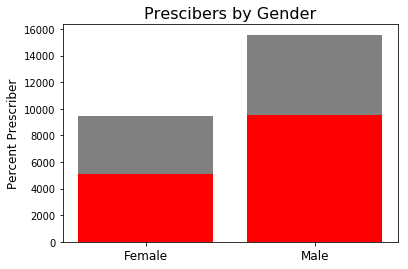

In [19]:
y_pos = np.arange(2)

plt.bar(y_pos, gender_presciber_df['Total.Prescriber'], color='grey')
plt.bar(y_pos, gender_presciber_df['Opioid.Prescriber'], color='red')
plt.xticks(y_pos, ["Female","Male"], fontsize=12)
plt.ylabel("Percent Prescriber", fontsize=12)
plt.title('Prescibers by Gender', fontsize=16)
#plt.xlabel(round(gender_presciber_df['Percent.Prescibers'], 5)*100)
plt.show()
#print(gender_presciber_df['Gender', 'Percent.Prescribers'])

## Separating out prediction column from input features

- And splitting the input features into train and test sets 

In [20]:
# Choose input and output variables
##########################################
# Didn't go with just categorical data
# Ends up being that all of one gender from one specialty in one state all get same prediction
# IE - All female dentists in NM are Opioid Prescribers, where all female dentists from UT are not prescribers
##########################################
input_features=presciber_df[['NPI', 'Gender1', 'State1', 'Specialty1']].values
opioid_prescriber=presciber_df['Opioid.Prescriber'].values

In [21]:
# Choose input and output variables
input_features_df=presciber_df.drop(['Opioid.Prescriber', 'Credentials', 'Gender', 'NPI', 'State', 'Specialty'], axis=1)
input_features=input_features_df.values 
opioid_prescriber=presciber_df['Opioid.Prescriber'].values

In [22]:
input_features

array([[ 0,  0,  0, ...,  1, 47, 18],
       [ 0,  0,  0, ...,  0,  3, 28],
       [ 0,  0,  0, ...,  0, 37, 27],
       ..., 
       [ 0,  0,  0, ...,  1,  5, 21],
       [ 0,  0,  0, ...,  0, 18, 24],
       [ 0,  0,  0, ...,  1, 37, 19]], dtype=int64)

In [23]:
# Split the Data
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(input_features, opioid_prescriber, train_size=0.75, random_state=1)

# Predicting Prescribers using all data
Dropping "uninteresting" NPI and Credentials columns


In [24]:
# Instantiate individual classifiers
lr = LogisticRegression(random_state=1)
knn = KNN()
dt = DecisionTreeClassifier(random_state=1)
rfc = RandomForestClassifier(random_state=1)
# Define a list called classifier that contains
# the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Classification Tree', dt),
('Random Forest', rfc)]

In [25]:
for clf_name, clf in classifiers:
#fit clf to the training set
    clf.fit(X_train, y_train)
# Predict the labels of the test set
    y_pred = clf.predict(X_test)
# Evaluate the accuracy of clf on the test set
    print('{:s} : {:.3f}'.format(clf_name,
    accuracy_score(y_test, y_pred)))

Logistic Regression : 0.912
K Nearest Neighbours : 0.858
Classification Tree : 0.888
Random Forest : 0.911


### Cross Validating

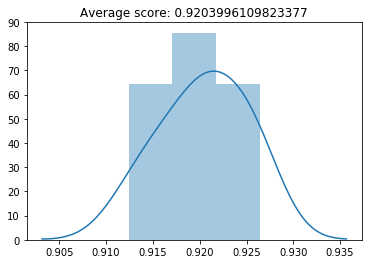

Logistic Regression : 0.912


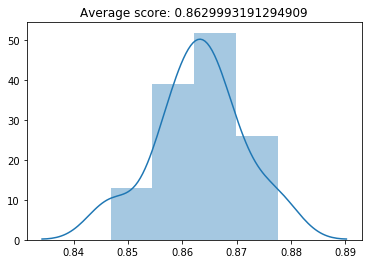

K Nearest Neighbours : 0.858


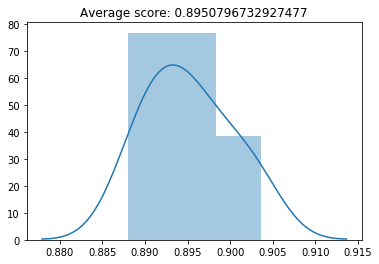

Classification Tree : 0.888


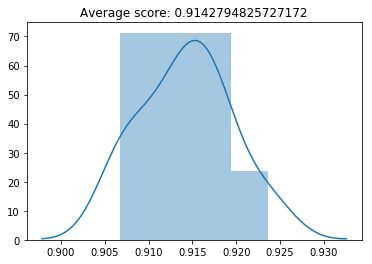

Random Forest : 0.911


In [26]:
for clf_name, clf in classifiers:
#fit clf to the training set
    clf.fit(X_train, y_train)
# Predict the labels of the test set
    y_pred = clf.predict(X_test)
# Evaluate the accuracy of clf on the test set
    cv_scores = cross_val_score(clf,input_features, opioid_prescriber, cv=10)
    sns.distplot(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    plt.show()
    print('{:s} : {:.3f}'.format(clf_name,
    accuracy_score(y_test, y_pred)))

### Determining feature importance 

In [27]:
df = pd.DataFrame(np.array(dt.feature_importances_).reshape(253,1), index = input_features_df.columns, columns=(['Importance']))
df.reset_index(level=0, inplace=True)
df10 = df.nlargest(10, 'Importance')
df10

,index,Importance
100,HYDROCODONE.ACETAMINOPHEN,0.472653
230,TRAMADOL.HCL,0.118706
181,OXYCODONE.ACETAMINOPHEN,0.078720
182,OXYCODONE.HCL,0.038524
251,State1,0.029454
1,ACETAMINOPHEN.CODEINE,0.026962
252,Specialty1,0.020500
12,AMOXICILLIN,0.010915
194,PREDNISONE,0.009779
142,METFORMIN.HCL,0.006898


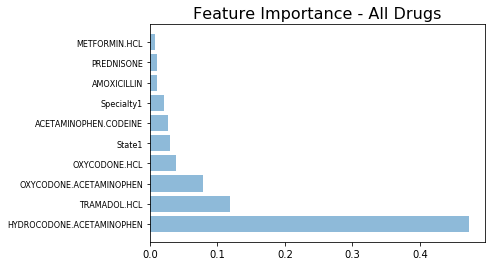

In [28]:
features = df10['index']
x_pos = np.arange(10)
importance = df10['Importance']

plt.barh(x_pos, importance, align='center', alpha=0.5)
plt.yticks(x_pos, features, fontsize=8)
plt.title('Feature Importance - All Drugs', fontsize=16)

plt.show()

### Bagging and Boosting

In [29]:
# Random Forest with Bagging
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16,
random_state=1)
bc = BaggingClassifier(base_estimator=dt, n_estimators=300,
n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

Accuracy of Bagging Classifier: 0.815


In [30]:
# Random Forest with Adaboost
dt = DecisionTreeClassifier(max_depth=2, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)
ada.fit(X_train, y_train)
y_pred_proba = ada.predict_proba(X_test)[:,1]

# Import roc_auc_score
from sklearn.metrics import roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.96


# Predicting Prescribers without opioid RX


Separating out the opioids using the opioid data

In [31]:
ops = list(re.sub(r'[-\s]','.',x) for x in opioids_df.values[:,0])
pops = list(set(ops) & set(presciber_df.columns))
pops

['FENTANYL',
 'HYDROCODONE.ACETAMINOPHEN',
 'HYDROMORPHONE.HCL',
 'METHADONE.HCL',
 'MORPHINE.SULFATE',
 'OXYCONTIN',
 'ACETAMINOPHEN.CODEINE',
 'MORPHINE.SULFATE.ER',
 'TRAMADOL.HCL',
 'OXYCODONE.HCL',
 'OXYCODONE.ACETAMINOPHEN']

In [32]:
# Choose input and output variables
input_features_df=presciber_df.drop(['Opioid.Prescriber', 'Credentials', 'Gender', 'NPI', 'State', 'Specialty'], axis=1) 
input_features_df1=input_features_df.drop(pops, axis=1)
input_features=input_features_df1.values
opioid_prescriber=presciber_df['Opioid.Prescriber'].values

Splitting then Training and Testing the data

In [33]:
# Split the Data
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(input_features, opioid_prescriber, train_size=0.75, random_state=1)

In [34]:
for clf_name, clf in classifiers:
#fit clf to the training set
    clf.fit(X_train, y_train)
# Predict the labels of the test set
    y_pred = clf.predict(X_test)
# Evaluate the accuracy of clf on the test set
    print('{:s} : {:.3f}'.format(clf_name,
    accuracy_score(y_test, y_pred)))

Logistic Regression : 0.759
K Nearest Neighbours : 0.778
Classification Tree : 0.779
Random Forest : 0.823


In [35]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [36]:
df = pd.DataFrame(np.array(dt.feature_importances_).reshape(242,1), index = input_features_df1.columns, columns=(['Importance']))
df.reset_index(level=0, inplace=True)
df10 = df.nlargest(10, 'Importance')
df10

,index,Importance
241,Specialty1,0.159956
87,GABAPENTIN,0.142013
240,State1,0.072697
167,OMEPRAZOLE,0.042908
42,CIPROFLOXACIN.HCL,0.039854
11,AMOXICILLIN,0.039546
119,LATANOPROST,0.021702
0,ABILIFY,0.021218
126,LISINOPRIL,0.019361
137,MELOXICAM,0.016940


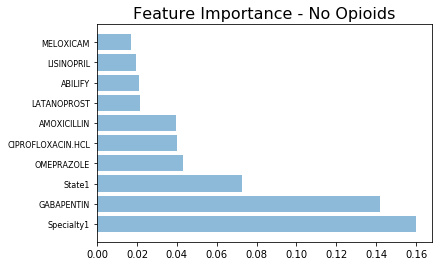

In [37]:
features = df10['index']
x_pos = np.arange(10)
importance = df10['Importance']

plt.barh(x_pos, importance, align='center', alpha=0.5)
plt.yticks(x_pos, features, fontsize=8)
plt.title('Feature Importance - No Opioids', fontsize=16)

plt.show()

### Bagging and Boosting

In [38]:
# Random Forest with Bagging
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16,
random_state=1)
bc = BaggingClassifier(base_estimator=dt, n_estimators=300,
n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

Accuracy of Bagging Classifier: 0.637


In [39]:
# Random Forest with Adaboost
dt = DecisionTreeClassifier(max_depth=2, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)
ada.fit(X_train, y_train)
y_pred_proba = ada.predict_proba(X_test)[:,1]

# Import roc_auc_score
from sklearn.metrics import roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.89


# Predicting Prescribers by Specialty "Internal Medicine"


Filtering on "Internal Medicine" as a Specialty

And without opioid RX again

In [40]:
# Choose input and output variables
presciber_df_IM=presciber_df.loc[presciber_df['Specialty'] == 'Internal Medicine']
input_features_df=presciber_df_IM.drop(['Opioid.Prescriber', 'Credentials', 'Gender', 'NPI', 'State', 'Specialty'], axis=1) 
input_features_df1=input_features_df.drop(pops, axis=1)
input_features=input_features_df1.values
opioid_prescriber=presciber_df_IM['Opioid.Prescriber'].values

Splitting then Training and Testing the data

In [41]:
# Split the Data
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(input_features, opioid_prescriber, train_size=0.75, random_state=1)

In [42]:
for clf_name, clf in classifiers:
#fit clf to the training set
    clf.fit(X_train, y_train)
# Predict the labels of the test set
    y_pred = clf.predict(X_test)
# Evaluate the accuracy of clf on the test set
    print('{:s} : {:.3f}'.format(clf_name,
    accuracy_score(y_test, y_pred)))

Logistic Regression : 0.847
K Nearest Neighbours : 0.812
Classification Tree : 0.805
Random Forest : 0.831


In [43]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [44]:
df = pd.DataFrame(np.array(dt.feature_importances_).reshape(242,1), index = input_features_df1.columns, columns=(['Importance']))
df.reset_index(level=0, inplace=True)
df10 = df.nlargest(10, 'Importance')
df10

,index,Importance
87,GABAPENTIN,0.270410
184,PREDNISONE,0.100534
240,State1,0.076277
123,LEVOFLOXACIN,0.044429
6,ALPRAZOLAM,0.035553
126,LISINOPRIL,0.024181
146,METOPROLOL.TARTRATE,0.023029
15,ATORVASTATIN.CALCIUM,0.022218
9,AMLODIPINE.BESYLATE,0.020262
42,CIPROFLOXACIN.HCL,0.018905


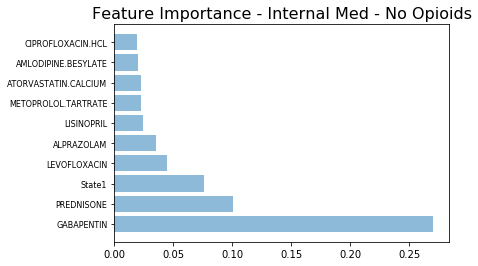

In [45]:
features = df10['index']
x_pos = np.arange(10)
importance = df10['Importance']

plt.barh(x_pos, importance, align='center', alpha=0.5)
plt.yticks(x_pos, features, fontsize=8)
plt.title('Feature Importance - Internal Med - No Opioids', fontsize=16)

plt.show()

### Bagging and Boosting

In [46]:
# Random Forest with Bagging
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16,
random_state=1)
bc = BaggingClassifier(base_estimator=dt, n_estimators=300,
n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

Accuracy of Bagging Classifier: 0.743


In [47]:
# Random Forest with Adaboost
dt = DecisionTreeClassifier(max_depth=2, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)
ada.fit(X_train, y_train)
y_pred_proba = ada.predict_proba(X_test)[:,1]

# Import roc_auc_score
from sklearn.metrics import roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.89


# Prescriber Outlier Analysis

The goal of this analysis is to determine if we can find discernible patterns in drug prescribing behavior of certain physicians compared to their peers.

In [48]:
# %% INITIALIZE DATA

#load libraries
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.metrics import silhouette_score
import math

#load data
df_opioids = pd.read_csv('opioids.csv')
df_od = pd.read_csv('overdoses.csv')
df_pres= pd.read_csv('prescriber-info.csv')

In [49]:
# %% SCRUB DATA

#map the credentials to be the same categories
df_pres['Credentials'].value_counts().head(20)

#remove periods from credentials, so they become the same
df_pres['Credentials'] = df_pres['Credentials'].str.replace('.','')
df_pres['Credentials'] = df_pres['Credentials'].str.replace('-','')
df_pres['Credentials'].value_counts().head(20)

MD         14060
DDS         1947
DO          1462
PAC         1027
DMD          731
PA           614
NP           581
OD           532
DPM          354
FNP          289
ARNP         273
CRNP         157
APRN         139
CNP           93
NPC           91
MD, PHD       85
FNPC          76
APN           70
FNPBC         56
RPAC          54
Name: Credentials, dtype: int64

In [50]:
# %% EXPLORATORY ANALYSIS

#how many unique providers are there?
df_pres['NPI'].nunique()

25000

In [51]:
#get a list of drug names in the prescribers data set
df_pres.columns
drug_cols = df_pres.columns.difference(['NPI','Gender','State','Credentials','Specialty','Opioid.Prescriber'])
drug_cols

Index(['ABILIFY', 'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS',
       'AGGRENOX', 'ALENDRONATE.SODIUM', 'ALLOPURINOL', 'ALPRAZOLAM',
       'AMIODARONE.HCL', 'AMITRIPTYLINE.HCL',
       ...
       'VENTOLIN.HFA', 'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN',
       'WARFARIN.SODIUM', 'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL',
       'ZOLPIDEM.TARTRATE'],
      dtype='object', length=250)

In [52]:
#get list of opioids
opioid_cols = ['MORPHINE.SULFATE.ER'
, 'FENTANYL'
, 'OXYCODONE.HCL'
, 'OXYCONTIN'
, 'MORPHINE.SULFATE'
, 'OXYCODONE.ACETAMINOPHEN'
, 'HYDROMORPHONE.HCL'
, 'METHADONE.HCL'
, 'HYDROCODONE.ACETAMINOPHEN'
, 'TRAMADOL.HCL'
, 'ACETAMINOPHEN.CODEINE']

In [53]:
#get a list of specialties
spec_cols = df_pres['Specialty'].unique()
spec_cols

array(['Dentist', 'General Surgery', 'General Practice',
       'Internal Medicine', 'Hematology/Oncology', 'Family Practice',
       'Nurse Practitioner', 'Optometry', 'Cardiology',
       'Obstetrics/Gynecology', 'Podiatry', 'Physician Assistant',
       'Diagnostic Radiology',
       'Student in an Organized Health Care Education/Training Program',
       'Neurology', 'Certified Nurse Midwife', 'Rheumatology',
       'Pharmacist', 'Urology', 'Cardiac Electrophysiology', 'Dermatology',
       'Emergency Medicine', 'Psychiatry & Neurology',
       'Infectious Disease', 'Psychiatry', 'Gastroenterology',
       'Ophthalmology', 'Thoracic Surgery', 'Oral Surgery (dentists only)',
       'Anesthesiology', 'Orthopedic Surgery', 'Otolaryngology',
       'Pulmonary Disease', 'Neuropsychiatry', 'Physical Therapist',
       'Pediatric Medicine', 'Physical Medicine and Rehabilitation',
       'Nephrology', 'Maxillofacial Surgery',
       'Certified Clinical Nurse Specialist', 'Preventive Medici

In [54]:
#see how many providers there are by specialty
df_pres['Specialty'].value_counts().head(20)
df_pres[df_pres['Opioid.Prescriber'] == 1]['Specialty'].value_counts().head(20)

Family Practice                                                   2635
Internal Medicine                                                 2426
Nurse Practitioner                                                1350
Physician Assistant                                               1262
Dentist                                                           1058
Emergency Medicine                                                1045
Orthopedic Surgery                                                 567
General Surgery                                                    442
Urology                                                            259
Student in an Organized Health Care Education/Training Program     245
Podiatry                                                           224
Hematology/Oncology                                                200
Neurology                                                          196
General Practice                                                   186
Physic

In [55]:
#see how many providers there are by state
df_pres['State'].value_counts()
df_pres[df_pres['Opioid.Prescriber'] == 1]['State'].value_counts().head(20)

CA    1462
TX     949
FL     875
NY     875
PA     679
OH     563
IL     555
MI     554
NC     498
GA     398
MA     369
WA     365
TN     358
NJ     344
VA     342
AZ     331
IN     324
MD     303
WI     292
MO     288
Name: State, dtype: int64

In [56]:
#see what % of opioid prescribers there are in each specialty
df_pres.groupby('Specialty')['Opioid.Prescriber'].agg('sum') / df_pres.groupby('Specialty').size()

Specialty
Addiction Medicine                                                0.666667
Allergy/Immunology                                                0.066116
Anesthesiology                                                    0.673913
Behavioral Analyst                                                0.000000
CRNA                                                              0.166667
Cardiac Electrophysiology                                         0.344828
Cardiac Surgery                                                   0.842105
Cardiology                                                        0.235465
Certified Clinical Nurse Specialist                               0.171429
Certified Nurse Midwife                                           0.062500
Chiropractic                                                      0.000000
Clinic/Center                                                     0.800000
Clinical Pharmacology                                             1.000000
Colon & Rectal 

In [57]:
#see what are the most popular drugs

##all drugs
df_pres[drug_cols].apply(lambda x: x.sum(), axis=0).sort_values(ascending=False).head(20)

df_pres[drug_cols].apply(lambda x: x.sum() / df_pres.shape[0], axis=0).sort_values(ascending=False).head(20)



LISINOPRIL                   47.04972
LEVOTHYROXINE.SODIUM         45.78896
AMLODIPINE.BESYLATE          44.31460
SIMVASTATIN                  41.30044
OMEPRAZOLE                   40.48952
ATORVASTATIN.CALCIUM         39.55640
HYDROCODONE.ACETAMINOPHEN    38.32328
FUROSEMIDE                   33.12644
METFORMIN.HCL                28.60648
METOPROLOL.TARTRATE          26.28052
GABAPENTIN                   26.17964
LOSARTAN.POTASSIUM           22.14876
HYDROCHLOROTHIAZIDE          21.47272
METOPROLOL.SUCCINATE         20.89616
WARFARIN.SODIUM              19.19804
CLOPIDOGREL                  18.10120
PRAVASTATIN.SODIUM           18.05732
CARVEDILOL                   16.60028
TRAMADOL.HCL                 16.26772
ALPRAZOLAM                   16.12812
dtype: float64

In [58]:
##opioids only
df_pres[opioid_cols].apply(lambda x: x.sum() / df_pres.shape[0], axis=0).sort_values(ascending=False).head(20)

HYDROCODONE.ACETAMINOPHEN    38.32328
TRAMADOL.HCL                 16.26772
OXYCODONE.ACETAMINOPHEN       9.71656
OXYCODONE.HCL                 6.89644
MORPHINE.SULFATE.ER           3.53220
FENTANYL                      3.41772
ACETAMINOPHEN.CODEINE         2.37040
OXYCONTIN                     1.99488
METHADONE.HCL                 1.43272
HYDROMORPHONE.HCL             0.92708
MORPHINE.SULFATE              0.82952
dtype: float64

In [59]:
# %% CLUSTER OUTLIER ANALYSIS

#come up with a list of states to run and specialities here. we'll use NY and PA as examples.
list_state = ['NY','IL','PA']
list_specialty = ['Internal Medicine','Family Practice']

------------------------
NY - Internal Medicine
Dimensions:  (233, 256)
% of Outlier in Cluster:  0.153465346535
Silhouette Score: 
0.578780343617


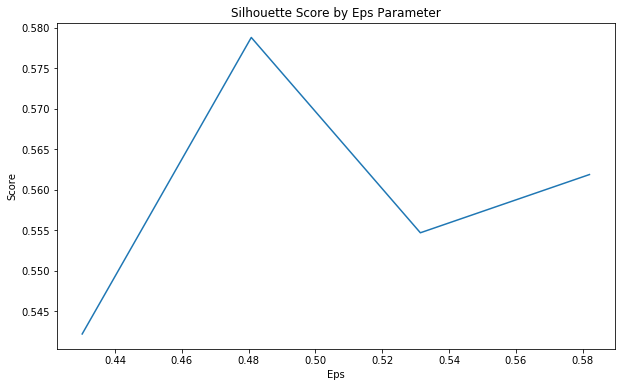

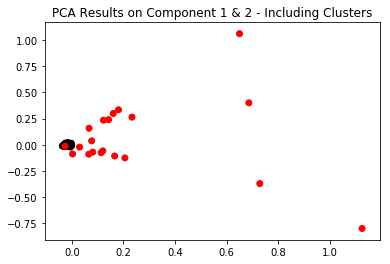

------------------------
------------------------
NY - Family Practice
Dimensions:  (102, 256)
% of Outlier in Cluster:  0.133333333333
Silhouette Score: 
0.62019188018


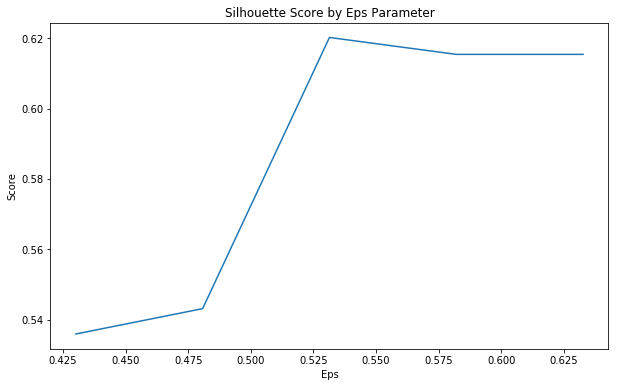

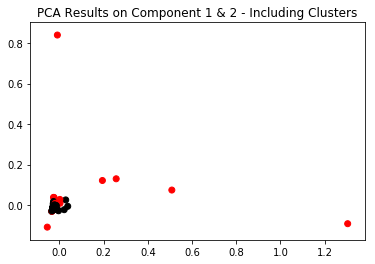

------------------------
------------------------
IL - Internal Medicine
Dimensions:  (109, 256)
% of Outlier in Cluster:  0.0283018867925
Silhouette Score: 
0.74040421299


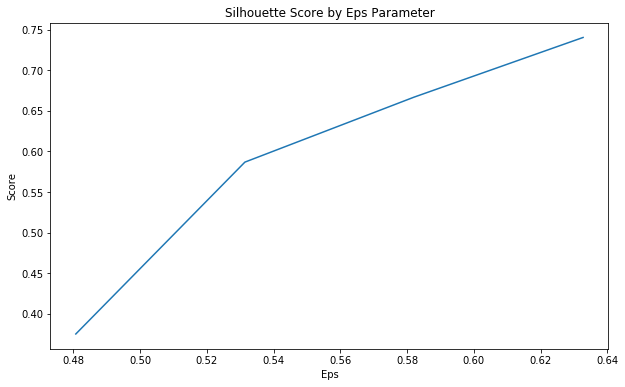

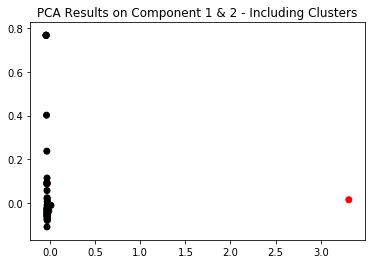

------------------------
------------------------
IL - Family Practice
Dimensions:  (103, 256)
% of Outlier in Cluster:  0.0957446808511
Silhouette Score: 
0.614189294665


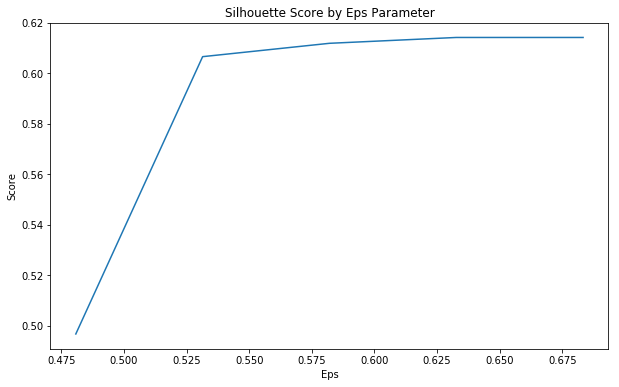

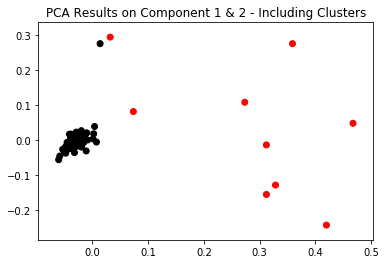

------------------------
------------------------
PA - Internal Medicine
Dimensions:  (109, 256)
% of Outlier in Cluster:  0.0283018867925
Silhouette Score: 
0.745714533417


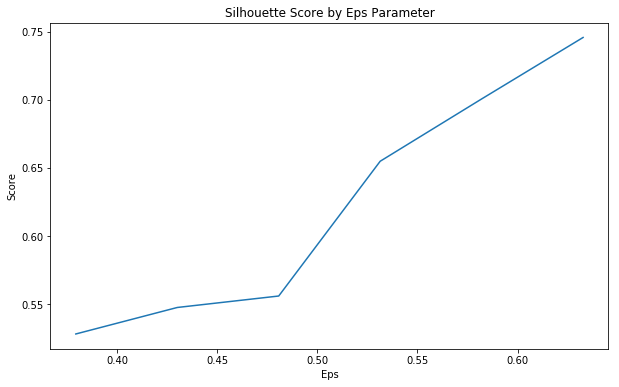

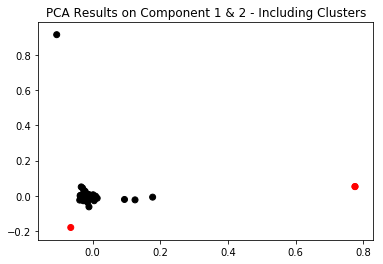

------------------------
------------------------
PA - Family Practice
Dimensions:  (145, 256)
% of Outlier in Cluster:  0.124031007752
Silhouette Score: 
0.555431995182


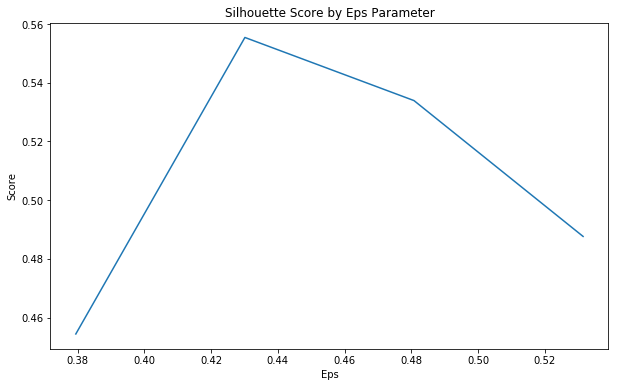

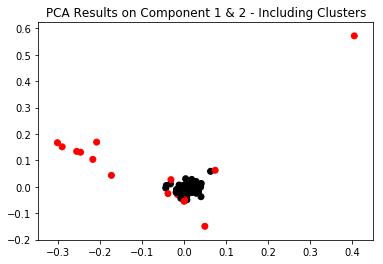

------------------------


In [60]:
for state in list_state:
    for specialty in list_specialty:
        
        print("------------------------")
        print(state + " - " + specialty)
        
        ##get a cluster data set
        df_cluster = df_pres[df_pres.Specialty == specialty] #filter on specialty
        df_cluster = df_cluster[df_cluster['Opioid.Prescriber'] == 1] #filter on opioids
        df_cluster = df_cluster[df_cluster['State'] == state] #filter on state
        
        #print dimensions
        print ("Dimensions: " , df_cluster.shape)

        #check the distrib by state
        df_cluster['State'].value_counts()
        df_cluster['Credentials'].value_counts()
        
        #TF-IDF - used in text document classification, basically calculates what % of the words (in this case, drugs) are in the following document (in this case, prescriber). And then scales this % by the inverse of how common a word is (where common is defined as the number of prescribers that prescribed this drug divided by the total number of providers)
        
        #get a column of just the drugs
        df_tf = df_cluster[drug_cols]
        
        #TF = TERM FREQUENCY
        
        #find the % of total prescriptions 
        df_tf = df_tf.apply(lambda x: x / x.sum(), axis=1)
        df_tf.sum(axis=1) #check, should be 1
        
        #IDF = INVERSE DOCUMENT FREQUNECY
        
        #find the % of doctors that prescribe each drug
        
        #keep only the drug columns we want
        df_idf = df_cluster[drug_cols]
        
        #save the number of providers for later
        n_providers = df_idf.shape[0]
        
        #create a binary 0/1 if the provider has the drug or not
        df_idf = np.minimum(df_idf,1)
        
        #sum the number of providers by drug
        df_idf = df_idf.sum()
        
        #create the idf factor, which is log(N/D) where N = total providers, D = providers that provided the drug
        df_idf = n_providers / df_idf
        df_idf = np.log(df_idf + 1)
        
        #TF-IDF
        
        #multiply the TF by the IDF to get the final tfidf
        df_tf_idf = df_tf * df_idf
        
        #remove all columns where value are always zero
        df_tf_idf = df_tf_idf.loc[:, (df_tf_idf != 0).any(axis=0)]
        
        #remove all columns where value are always nan
        df_tf_idf = df_tf_idf.loc[:, (df_tf_idf.notnull()).any(axis=0)]
        
        # %% CLUSTER OUTLIER ANALYSIS - RUN CLUSTER ANALYSIS
        
        ##KMEANS
        
        #import library
        from sklearn.cluster import KMeans
        
        #create the kmeans model object
        kmeans = KMeans(n_clusters=2, random_state = 0)
        
        #fit the model object
        kmeans = kmeans.fit(X = df_tf_idf)
        
        #get the cluster labels for each object
        df_cluster['cluster_kmeans'] = kmeans.predict(X = df_tf_idf)
        
        #check out the distribution of cluster labels
        df_cluster['cluster_kmeans'].value_counts()
        
        ##DBSCAN
        
        #import library
        from sklearn.cluster import DBSCAN
        
        #do a quick routine to determine some optimal eps parameters...
        list_eps = np.linspace(start=0.025,stop=2,num=40)
        result_iter = []
        result_eps = []
        for eps_iter in list_eps:
            #create the dbscan model object
            dbsc = DBSCAN(eps = eps_iter, min_samples = 3, metric = 'cosine')
            
            #fit the model object
            dbsc = dbsc.fit(X = df_tf_idf)
            
            #get the cluster labels for each object
            df_cluster['cluster_dbsc'] = dbsc.labels_
            
            #check out the distribution of cluster labels
            df_cluster['cluster_dbsc'].value_counts()
            
            #if the label is -1, treat it as an outlier because it does not match to a core point
            df_cluster.loc[df_cluster['cluster_dbsc'] == -1, 'cluster_dbsc'] = 1
            
            #if the label is not 0, assume they are outliers
            df_cluster.loc[df_cluster['cluster_dbsc'] != 0, 'cluster_dbsc'] = 1
            
            #determine a percent cluster
            thresh_perc = 0.025 #the minimum number % of obs in the outlier cluster
            thresh_perc_max = 0.25 #the maximum % of obs in the outlier cluster
            
            #if there's no clusters, set the percent of obs in cluster to zero
            if df_cluster['cluster_dbsc'].value_counts().shape[0] > 1:
                perc_cluster = df_cluster['cluster_dbsc'].value_counts()[1]/df_cluster['cluster_dbsc'].value_counts()[0]
            else:
                perc_cluster = 0
            
            if (perc_cluster > thresh_perc and perc_cluster < thresh_perc_max):
                #print("Silhouette Score at Eps: ", eps_iter)
                #print(silhouette_score(df_tf_idf, dbsc.labels_))
                result_iter.append(eps_iter)
                result_eps.append(silhouette_score(df_tf_idf, dbsc.labels_))
                
        #plot the object
        fig, ax = plt.subplots(figsize=(10,6))
        
        ax.set_title('Silhouette Score by Eps Parameter')
        ax.set_ylabel('Score')
        ax.set_xlabel('Eps')
        plt.plot(result_iter, result_eps)
        
        #choose the eps that had the highest silhouette score
        if len(result_eps) == 0 :
            chosen_eps = 0.5
        else:
            chosen_eps = pd.DataFrame(result_iter)
            chosen_eps = chosen_eps[result_eps == max(result_eps)].values[0]
        
        #create the dbscan model object
        dbsc = DBSCAN(eps = chosen_eps, min_samples = 3, metric = 'cosine')
        
        #fit the model object
        dbsc = dbsc.fit(X = df_tf_idf)
        
        #get the cluster labels for each object
        df_cluster['cluster_dbsc'] = dbsc.labels_
        
        #check out the distribution of cluster labels
        df_cluster['cluster_dbsc'].value_counts()
        
        #if the label is -1, treat it as an outlier because it does not match to a core point
        df_cluster.loc[df_cluster['cluster_dbsc'] == -1, 'cluster_dbsc'] = 1
        
        #if the label is not 0, assume they are outliers
        df_cluster.loc[df_cluster['cluster_dbsc'] != 0, 'cluster_dbsc'] = 1
        
        #check out the distribution of cluster labels
        df_cluster['cluster_dbsc'].value_counts()
        
        #if there's no clusters, set the percent of obs in cluster to zero
        if df_cluster['cluster_dbsc'].value_counts().shape[0] > 1:
            perc_cluster = df_cluster['cluster_dbsc'].value_counts()[1]/df_cluster['cluster_dbsc'].value_counts()[0]
        else:
            perc_cluster = 0
            
        print("% of Outlier in Cluster: ", perc_cluster)
        
        #check silhoutte score
        #a silhouette score is from -1 to 1 and is based on both how close the points are together in their cluster (their density) AND the distance between the other clusters (their distinctness or lack of overlap). a score of 1 is the best, -1 is the worst. 0 signifies overlap in your clusters
        silhouette_score(df_tf_idf, dbsc.labels_)
        print("Silhouette Score: ")
        print(silhouette_score(df_tf_idf, dbsc.labels_))
        
        ##HIERARCHICAL CLUSTERING
        
        #import library
        from sklearn.cluster import AgglomerativeClustering
        
        #create the agglomerative cluster
        agglo_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
        
        #fit the model object
        agglo_cluster = agglo_cluster.fit(X = df_tf_idf)
        
        #get the cluster labels for each object
        df_cluster['cluster_agglo'] = agglo_cluster.labels_
        
        #check out the distribution of cluster labels
        df_cluster['cluster_agglo'].value_counts() 
        
        
        # %% CLUSTER OUTLIER ANALYSIS - VISUALIZE CLUSTER ANALYSIS
        
        ##PCA
        
        #import libraries
        from sklearn.decomposition import PCA
        
        #create the model
        n_components = df_tf_idf.shape[1]
        pca = PCA(n_components)
        
        #fit the model
        pca = pca.fit(df_tf_idf)
        
        #get pca results
        pca_results = pca.transform(df_tf_idf)
        pca_results = pd.DataFrame(pca_results)
        
        #create a pca dataframe
        df_pca = pd.DataFrame()
        df_pca['x'] = pca_results.iloc[:,0].values
        df_pca['y'] = pca_results.iloc[:,1].values
        df_pca['label'] = df_cluster['cluster_dbsc'].values
        
#        #plot the results - without clusters
#        plt.figure()
#        plt.scatter(x = df_pca['x'], y = df_pca['y'])
#        plt.title("PCA Results on Component 1 & 2")
#        plt.show()
            
        #plot the results - with clusters
        plt.figure()
        plt.scatter(x = df_pca['x'], y = df_pca['y'], c = df_pca['label'], cmap=matplotlib.colors.ListedColormap(['black','red']))
        plt.title("PCA Results on Component 1 & 2 - Including Clusters")
        plt.show()
        
        print("------------------------")

From this point onwards, I'll do analysis on a single iteration of the cluster analysis.

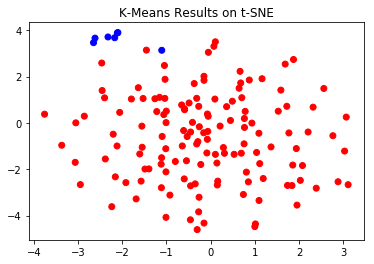

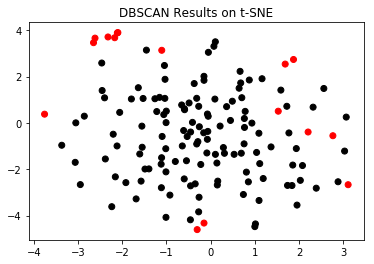

In [61]:
##TSNE

#import library
%matplotlib inline
from sklearn.manifold import TSNE

#create the model
tnse = TSNE(learning_rate=100, random_state = 100618)

#transform using t-SNE
tnse_transformed = tnse.fit_transform(df_tf_idf)

#plot the t-SNE results
labels = df_cluster['cluster_kmeans']
xs = tnse_transformed[:,0]
ys = tnse_transformed[:,1]
plt.scatter(xs,ys, c = labels.values, cmap=matplotlib.colors.ListedColormap(['red','blue']))
plt.title("K-Means Results on t-SNE")
plt.show()

#plot the t-SNE results
labels = df_cluster['cluster_dbsc']
xs = tnse_transformed[:,0]
ys = tnse_transformed[:,1]
plt.scatter(xs,ys, c = labels.values, cmap=matplotlib.colors.ListedColormap(['black','red']))
plt.title("DBSCAN Results on t-SNE")
plt.show()

In [62]:
# %% CLUSTER OUTLIER ANALYSIS - FIND CLUSTER CHARACTERISTICS

#let's see how the found clusters vary by drugs prescribed

#we'll take group averages, and then compare
df_cluster_groups = df_cluster.groupby('cluster_dbsc')[drug_cols].sum()
df_cluster_groups_2 = df_cluster_groups.apply(lambda x: x / x.sum(), axis=1)

#find differences
diffs = pd.DataFrame()
diffs['inliers_perc'] = df_cluster_groups_2.loc[0,:] * 100
diffs['outliers_perc'] = df_cluster_groups_2.loc[1,:] * 100
diffs['diff_perc'] =  diffs['outliers_perc'] - diffs['inliers_perc']

#get list of columns in the data set
index_cols = diffs.index.values.tolist()

#for the opioid cols, make the opioid indicator as yes
diffs['Is Opioid?'] = 'No'
diffs.loc[set(opioid_cols).intersection(index_cols), 'Is Opioid?'] = 'Yes'
diffs = diffs.round(decimals=1)

#let's look at the top 20 differences of what the outliers are prescribing vs inliers
findings = diffs.sort_values(by=['diff_perc'], ascending=False)
findings.columns = ['Inliers %', 'Outliers %', 'Difference', 'Is Opioid?']
findings.head(20)


,Inliers %,Outliers %,Difference,Is Opioid?
OXYCODONE.HCL,0.5,11.7,11.2,Yes
OXYCODONE.ACETAMINOPHEN,0.6,4.3,3.7,Yes
HYDROCODONE.ACETAMINOPHEN,1.8,4.8,3.0,Yes
ALPRAZOLAM,1.2,3.5,2.3,No
AZITHROMYCIN,0.6,2.3,1.8,No
PREDNISONE,0.7,2.5,1.8,No
CEPHALEXIN,0.2,1.9,1.7,No
DIAZEPAM,0.2,1.3,1.1,No
DOXYCYCLINE.HYCLATE,0.1,1.1,1.0,No
CIPROFLOXACIN.HCL,0.4,1.3,0.9,No


In [63]:
#focus on opioids only
findings_opioids_only = findings[findings['Is Opioid?'] == 'Yes']
findings_opioids_only

,Inliers %,Outliers %,Difference,Is Opioid?
OXYCODONE.HCL,0.5,11.7,11.2,Yes
OXYCODONE.ACETAMINOPHEN,0.6,4.3,3.7,Yes
HYDROCODONE.ACETAMINOPHEN,1.8,4.8,3.0,Yes
METHADONE.HCL,0.0,0.8,0.7,Yes
OXYCONTIN,0.2,0.6,0.4,Yes
MORPHINE.SULFATE.ER,0.2,0.5,0.3,Yes
HYDROMORPHONE.HCL,0.0,0.0,-0.0,Yes
MORPHINE.SULFATE,0.1,0.0,-0.1,Yes
FENTANYL,0.3,0.2,-0.1,Yes
ACETAMINOPHEN.CODEINE,0.1,0.0,-0.1,Yes


Conclusion: We've been able to identify certain discernible patterns in drug prescribing behaviors from physicians relative to their peers in their specialties. These anomalous drug patterns tended to prescribe higher than average amounts of opioids. The next step would be to validate findings with domain experts. If these prescribing patterns are indeed red flags, we'll have to see what actions can be taken, if any.

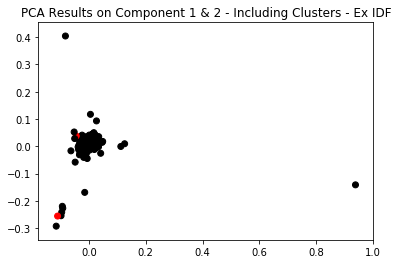

In [64]:
# %% CLUSTER OUTLIER ANALYSIS - CHECK IMPACT OF IDF WEIGHING

#curious to see how the results would have changed if we did not use TF-IDF.

#fit the model object
dbsc_ex_idf = dbsc.fit(X = df_tf)

#get the cluster labels for each object
df_cluster['cluster_dbsc_ex_idf'] = dbsc_ex_idf.labels_

#check out the distribution of cluster labels
df_cluster['cluster_dbsc_ex_idf'].value_counts()

#if the label is -1, treat it as an outlier because it does not match to a core point
df_cluster.loc[df_cluster['cluster_dbsc_ex_idf'] == -1, 'cluster_dbsc_ex_idf'] = 1

#if the label is not 0, assume they are outliers
df_cluster.loc[df_cluster['cluster_dbsc_ex_idf'] != 0, 'cluster_dbsc_ex_idf'] = 1

#DO PCA ON NON-IDF DATA

#create the model
n_components = df_tf_idf.shape[1]
pca = PCA(n_components)

#fit the model
pca = pca.fit(df_tf)

#get pca results
pca_results = pca.transform(df_tf)
pca_results = pd.DataFrame(pca_results)

#create a pca dataframe
df_pca = pd.DataFrame()
df_pca['x'] = pca_results.iloc[:,0].values
df_pca['y'] = pca_results.iloc[:,1].values
df_pca['label'] = df_cluster['cluster_dbsc_ex_idf'].values

#plot the results
df_pca['label_dbsc_ex_idf'] = df_cluster['cluster_dbsc_ex_idf'].values
plt.figure()
plt.scatter(x = df_pca['x'], y = df_pca['y'], c = df_pca['label_dbsc_ex_idf'], cmap=matplotlib.colors.ListedColormap(['black','red']))
plt.title("PCA Results on Component 1 & 2 - Including Clusters - Ex IDF")
plt.show()

Clusters are indistinguishable when data is not scaled.